# Reproducing the simulations from Angelopoulos et al. (2021)

In this tutorial, we use :class:`mapie.regression.MapieClassifier` to reproduce the results of Experiment 1 from Angelopoulos et al. (2021). In this Experiment, the so-called "Naive", "Top-K", and Adaptive Prediction Set methods are used to estimate the the coverage levels and mean prediction set sizes obtained with various deep learning models on the Image Net dataset.

The pre-trained neural networks are downloaded from `torchvision` and are made compatible with the `scikit-learn` API thanks to a custom class. The images are downloaded from ...

Before starting the tutorial, we need to install the `torch`, `torchvision`, and `opencv` packages which are not available in the default MAPIE environment. 

In [3]:
import os
import glob
import random
import re
import sys
import zipfile

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import torchvision.models as models
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from mapie.metrics import classification_coverage_score
from mapie.classification import MapieClassifier

%matplotlib inline

## 1. Loading the data

In [13]:
!kaggle datasets download -d ifigotin/imagenetmini-1000

100%|█████████████████████████████████████▉| 3.92G/3.92G [01:50<00:00, 33.0MB/s]
100%|██████████████████████████████████████| 3.92G/3.92G [01:50<00:00, 38.1MB/s]


In [5]:
# PATH_IMG_ZIP = '/workspace/imagenetmini-1000.zip'
# PATH_IMG_UNZIP  = '/workspace/MAPIE/Test Imagenet'
#with zipfile.ZipFile(PATH_IMG_ZIP, 'r') as zip_ref:
#    zip_ref.extractall(PATH_IMG_UNZIP)

In [8]:
def get_labels(path_labels):
    with open(path_labels, 'r') as f:
        content = f.read()

    content = content.split('\n')

    labels = []
    for l in content :
        labels.append([l[:9], l[9:]])
    
    return labels # [:-1]

labels = get_labels(PATH_LABELS)

In [11]:
def get_images(path_imgs, labels, n_images='all'):
    if n_images=='all':
        img_paths = glob.glob(os.path.join(path_imgs, '*', '*'))
        random.shuffle(img_paths)
    else:
        img_paths = sorted(random.sample(glob.glob(os.path.join(path_imgs, '*', '*')), n_images))
        
    dim_calib = len(img_paths)//2
    dim_test = len(img_paths) - dim_calib
    X = np.zeros((dim_calib, 256, 256, 3)).astype('uint8')
    X_test = np.zeros((dim_test, 256, 256, 3)).astype('uint8')
    y_true = np.zeros((dim_test, 1000))

    y, y_test = [], []
    for i, img_path in enumerate(img_paths):
        x = cv2.imread(img_path)
        x = cv2.resize(x, (256, 256))
        if i < dim_calib:
            X[i] = x
        else:
            X_test[i-dim_calib] = x
        label_num = re.findall('n\d{8}', img_path)[0]
        for indice, l in enumerate(labels):
            if l[0] == label_num:
                if i < dim_calib:
                    y.append(indice)
                else:
                    y_test.append(indice)
                    # y_true[i-dim_calib][indice] = 1
    y_true = preprocessing.label_binarize(y=y_test, classes=np.arange(max(y_test)+1))

    return X, y, X_test, y_test, y_true

X, y, X_test, y_test, y_true = get_images(PATH_VAL, labels, n_images='all')

In [12]:
y_true = preprocessing.label_binarize(y=y_test, classes=np.arange(max(y_test)+1))

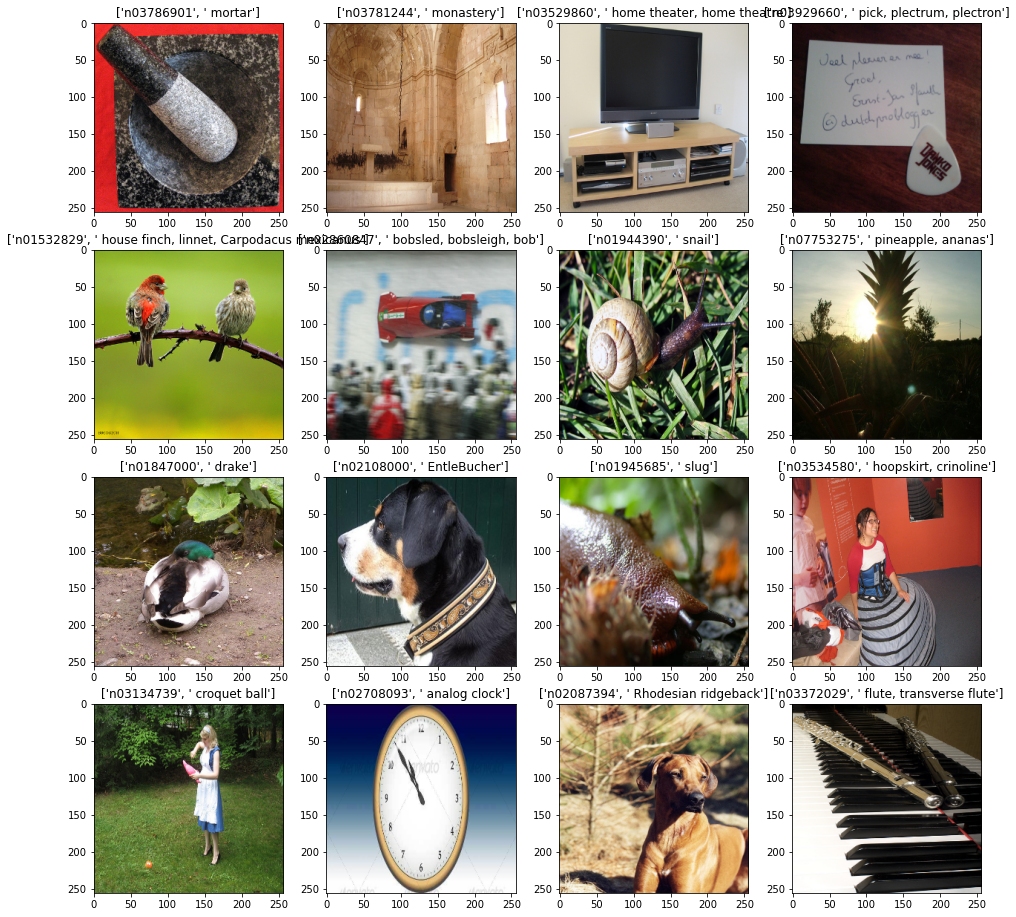

In [13]:
#Check data
f, ax = plt.subplots(4, 4, figsize=(16, 16))
indexes = [i for i in range(16)]
count = 0
for i in range(4):
    for j in range(4):
        index = indexes[count]
        ax[i, j].imshow(X_test[index][:, :, ::-1])
        ax[i, j].set_title(labels[y_test[index]])
        count += 1

## 2. Loading the models

In order to use a PyTorch model in `MapieClassifier`, we first need to convert it to the `scikit-learn` API. It can be done with a class like the following one.

In [9]:
class TorchToMapie():
    
    def __init__(self, torch_model, transform, batch_size):
        self.transform = transform
        self.torch_model = torch_model.cuda()
        self.trained_ = True
        self.batch_size = batch_size
        n_classes = [mod for mod in torch_model.modules()][-1].out_features
        self.classes_ = np.arange(n_classes)
        
    
    def fit(self, X, y=None):
        pass
    
    def predict_proba(self, X):
        preds = np.zeros((len(X), 1000))
        model = self.torch_model.eval()
        X_t = torch.zeros((len(X), 3, 224, 224)).type(torch.float32)
        for i, x in enumerate(X):
            x = x.astype('uint8')
            x_t = self.transform(x)
            X_t[i] = torch.unsqueeze(x_t, 0)
        BATCH_SIZE = min(len(X), self.batch_size)
        for batch in range(len(X)//BATCH_SIZE + 1):
            X_t_temp = X_t[batch*BATCH_SIZE:min((batch + 1)*BATCH_SIZE, len(X))]
            X_t_temp = X_t_temp.cuda()
            pred = model(X_t_temp)
            pred = torch.nn.functional.softmax(pred, dim=1)
            pred = np.reshape(pred.cpu().detach().numpy(), (len(X_t_temp), 1000))
            preds[batch*BATCH_SIZE:min((batch + 1)*BATCH_SIZE, len(X))] = pred
        
        return preds
        
    
    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = (pred_proba == pred_proba.max(axis=1)[:,None]).astype(int)
        
        return pred
    
    def __sklearn_is_fitted__(self):
        return True

In [10]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize(256),                   
     transforms.CenterCrop(224),               
     transforms.ToTensor(),                    
     transforms.Normalize(                     
     mean=[0.485, 0.456, 0.406],               
     std=[0.229, 0.224, 0.225])
])


In [6]:
models = {
    'resnext101': models.resnext101_32x8d(pretrained=True),
    'resnet152': models.resnet152(pretrained=True),
    'resnet101': models.resnet101(pretrained=True),
    'resnet50': models.resnet50(pretrained=True),
    'resnet18': models.resnet18(pretrained=True),
    'densenet161': models.densenet161(pretrained=True),
    'vgg16': models.vgg16(pretrained=True),
    'inception': models.inception_v3(pretrained=True),
    'shufflenet': models.shufflenet_v2_x1_0(pretrained=True)
}

## 3. Estimating the prediction sets

In [14]:
def count_null_set(y):
    count = 0
    for pred in y[:, :, 0]:
        if np.sum(pred) == 0:
            count += 1
    return count
        

In [20]:
random_state = 42
alpha = 0.1
batch_size = 8

In [24]:
%%time
methods = ["naive", "score", "cumulated_score", "top_k"]
mdl = list(ALL_MODELS.keys())[0]
y_preds, pred_sets = {}, {}
for name, model in ALL_MODELS.items():
    torch.cuda.empty_cache()
    mapie_model = TorchToMapie(model, transform, batch_size)
    y_preds_, pred_sets_ = {}, {}
    for method in methods:
        print(f"{name} {method}")
        mapie = MapieClassifier(
            estimator=mapie_model,
            method=method,
            cv="prefit",
            random_state=random_state
        )
        mapie.fit(X, y, image_input=True)
        y_preds_[method], pred_sets_[method] = mapie.predict(
            X_test, alpha=alpha, include_last_label="randomized"
        )
    y_preds[name], pred_sets[name] = y_preds_, pred_sets_

resnext101 naive
4.6838937883819654e-07
4.70133004526474e-07
resnext101 score
4.6838937883819654e-07
4.70133004526474e-07
resnext101 cumulated_score
4.6838937883819654e-07
4.70133004526474e-07
resnext101 top_k
4.6838937883819654e-07
4.70133004526474e-07
resnet152 naive
3.9413008723343523e-07
5.511656162582312e-07
resnet152 score
3.9413008723343523e-07
5.511656162582312e-07
resnet152 cumulated_score
3.9413008723343523e-07
5.511656162582312e-07
resnet152 top_k
3.9413008723343523e-07
5.511656162582312e-07
resnet101 naive
3.890584518995155e-07
3.9062309575843557e-07
resnet101 score
3.890584518995155e-07
3.9062309575843557e-07
resnet101 cumulated_score
3.890584518995155e-07
3.9062309575843557e-07
resnet101 top_k
3.890584518995155e-07
3.9062309575843557e-07
resnet50 naive
3.7880879732998807e-07
4.813640264167418e-07
resnet50 score
3.7880879732998807e-07
4.813640264167418e-07
resnet50 cumulated_score
3.7880879732998807e-07
4.813640264167418e-07
resnet50 top_k
3.7880879732998807e-07
4.81364026

In [25]:
nulls, coverages, accuracies, widths = {}, {}, {}, {}
for name, model in ALL_MODELS.items():
    nulls_, coverages_, accuracies_, widths_ = {}, {}, {}, {}
    for method in methods:
        nulls_[method] = count_null_set(pred_sets[name][method])
        coverages_[method] = classification_coverage_score(
            y_test, pred_sets[name][method][:, :, 0]
        )
        accuracies_[method] = accuracy_score(y_true, y_preds[name][method])
        widths_[method] = pred_sets[name][method][:, :, 0].sum(axis=1).mean()
    coverages[name] = coverages_
    accuracies[name] = accuracies_
    nulls[name] = nulls_
    widths[name] = widths_

In [26]:
summary_df = pd.concat(
    [
        pd.DataFrame(coverages).T,
        pd.DataFrame(nulls).T,
        pd.DataFrame(widths).T
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [27]:
summary_df.style.set_precision(3)

## Old cells

In [ ]:
# all_in_one = pd.DataFrame(
#     recap_all_in_one,
#     columns=['model_name', 
#                              'accuracy', 
#                              'average size of naive prediction set', 
#                              'naive coverage',
#                              'number of null sets for naive method',
#                              'average size of prediction set with score method ',
#                              'score method coverage',
#                              'number of null sets for score method',
#                              'average size of prediction set with culumated score method',
#                              'number of null sets for cumulated score method',
#                              'cumulated score coverage',
#                              'average size of prediction set with randomized culumated score method',
#                              'number of null sets for randomized cumulated score method',
#                              'randomized cumulated score coverage',
#                              'average size of top-k prediciton set', 
#                              'top-k coverage',
#                              'number of null sets for top-k method',
#                              ])

# all_in_one

In [ ]:

# nulls[name], coverages[name], accuracies[name],
#         nulls_[method] = count_null_set(y_ps)
#         coverages_[method] = classification_coverage_score(y_test, y_ps[:, :, 0])
#         accuracies_[method] = accuracy_score(y_true, y_pred)
# print(name, coverages[name])
#     recap_all_in_one.append([model[0], 
#                              accuracy_score(y_true, y_pred),
#                              np.sum(y_naive)/len(X_test),
#                              naive_coverage,
#                              null_naive,
#                              np.sum(y_score)/len(X_test),
#                              score_coverage,
#                              null_score,
#                              np.sum(y_aps)/len(X_test),
#                              null_aps,
#                              aps_coverage,
#                              np.sum(y_aps_random)/len(X_test),
#                              null_aps_random,
#                              aps_coverage_random,
 
#                              np.sum(y_topk)/len(X_test),
#                              null_topk,
#                              topk_coverage])
   

In [15]:
# from sklearn import preprocessing
# y_true = preprocessing.LabelBinarizer(sparse_output=True).fit(y).transform(y)
# y_true2 = preprocessing.LabelBinarizer(sparse_output=False).fit(y).transform(y)
# y_true3 = preprocessing.label_binarize(y=y, classes=np.arange(max(y)+1))

In [16]:
# mapie_model = TorchToMapie(model, transform, BATCH_SIZE)
# mapie = MapieClassifier(
#     estimator=mapie_model, method="cumulated_score", cv="prefit", random_state=42
# )
# mapie.fit(X, y, image_input=True)
# y_pred, y_ps = mapie.predict(X_test, alpha=0.1, include_last_label="randomized")

In [17]:
# from typing_extensions import TypedDict
# Params = TypedDict("Params", {"method": str, "cv": int})
# STRATEGIES = {
#     "jackknife_plus": Params(method="plus", cv=-1),
#     "jackknife_minmax": Params(method="minmax", cv=-1),
#     "cv_plus": Params(method="plus", cv=10),
#     "cv_minmax": Params(method="minmax", cv=10),
# }